# note5


- 過渡状態の学習データで学習 → その結果によって学習率を回路パラメータごとに変更して定常状態のところを使って再学習
- GRU の学習は定常のみ


In [117]:
from dataclasses import asdict, dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.signal import filtfilt, firwin
from torch import nn, optim

from src.utils.load_data import path_list
from src.utils.models import BuckConverterCell, GRUModel
from src.utils.plot_data import (
    plot_buck_gru_components_tail,
    plot_compare_tail,
    plot_iLvC,
    plot_param_learning_progress,
    plot_u_vs_iL_vC,
)
from src.utils.save_log import (
    create_result_dir,
    init_log,
    save_figure_to_log,
)

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [118]:
keep_log: bool = True
keep_log: bool = False


@dataclass(frozen=True)
class Params:
    # data_path: str = path_list.path2
    # data_path: str = "../../data/buck_sim_Vin10.0_Vref5.0_fs100000.0_ppc1000_cyc1000/buck_sim_Vin10.0_Vref5.0_fs100000.csv"
    data_path: str = "../../data/OpenLoop_Nr_2050_TS_5e-8.csv"

    # 真値パラメータ
    L_true: float = 223.6e-6
    C_true: float = 73.8e-6
    R_true: float = 5
    L_init = 200e-6
    C_init = 100e-6
    R_init = 8.0

    dt: float = 5e-8

    Vin: int = 10
    f_sw: float = 1e5  # スイッチング周波数
    T: float = 1 / f_sw

    # BuckConverterCell
    lr_l = 1e-2
    lr_c = 1e-2
    lr_r = 2e-2

    epochs = 10000

    # GRU
    seq_length = 10

    gru_lr = 0.001
    gru_epochs = 200


params = Params()


In [119]:
# ログ保存の初期化
if keep_log:
    result_dir = create_result_dir(
        "note5",
        base_dir="results/actual",
        config_dict=asdict(params),
    )
    log_path = init_log(result_dir, "actual_machine_notebooks/note5/note.ipynb")

# BuckConverterCell


## 前処理


len(t_raw)=500000
len(iL_raw)=500000
len(vC_raw)=500000


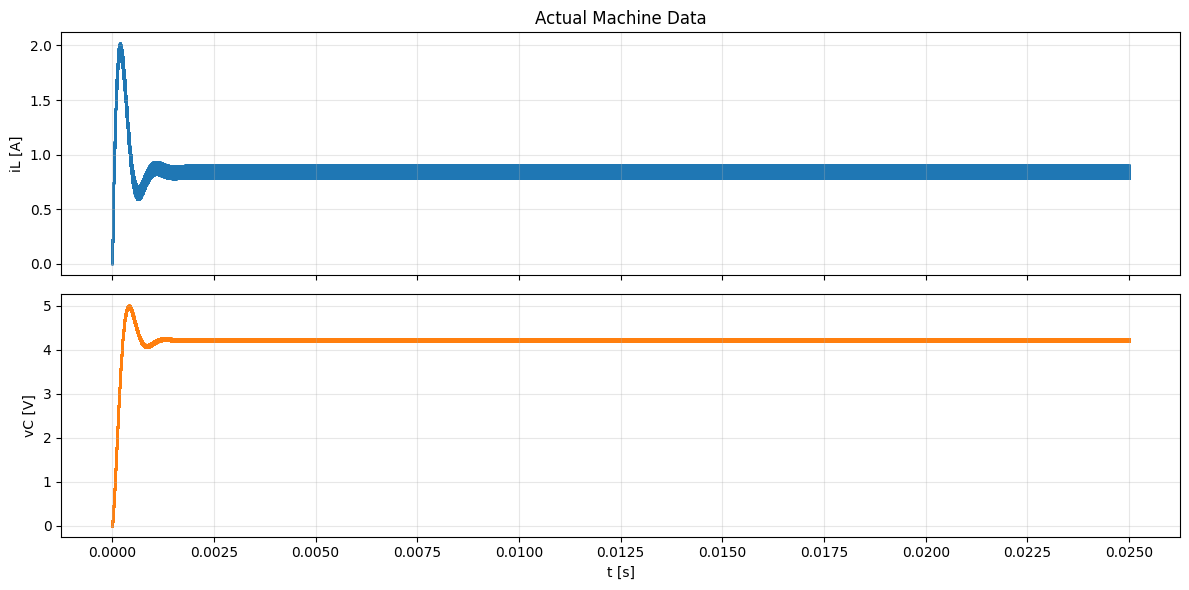

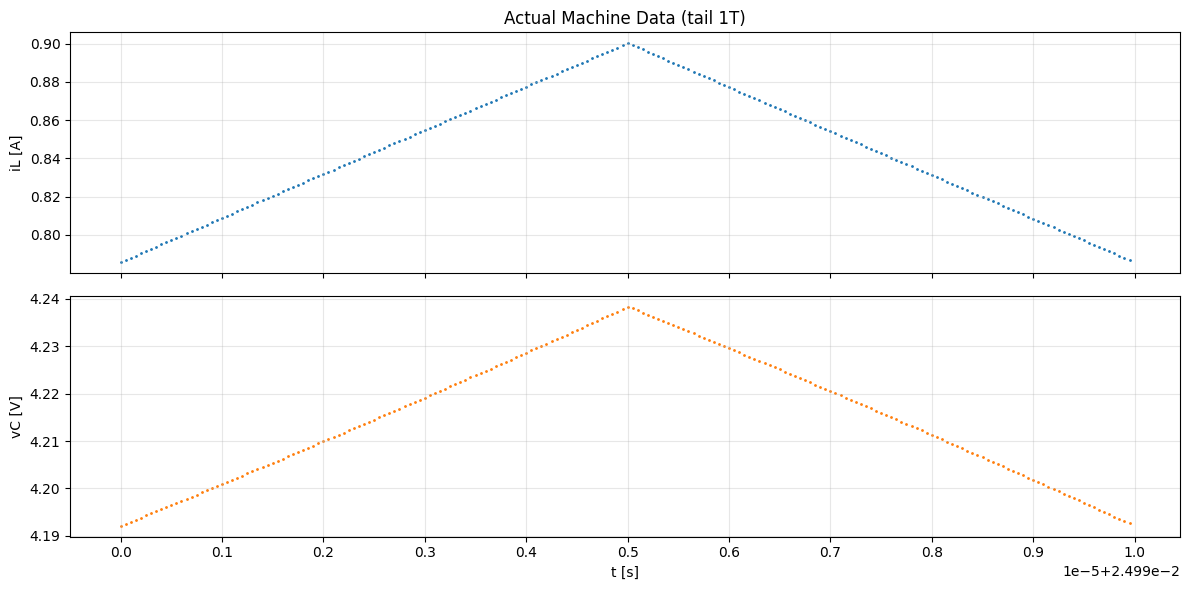

In [120]:
# time_label = "TIME"
# time_label = "t"
time_label = "Time"
# iL_label = "CH2"
iL_label = "iL"
# vC_label = "CH1"
# vC_label = "vC"
vC_label = "vo"

# データの読み込み
# df = pd.read_csv(params.data_path)
df = pd.read_csv(params.data_path, skiprows=0)

mask: np.ndarray = df[time_label].to_numpy(dtype=np.float64) >= -0.0
# mask: np.ndarray = df[time_label].to_numpy(dtype=np.float64) >= -0.000080
t_raw_full: np.ndarray = df.loc[mask, time_label].to_numpy(dtype=np.float64)  # 秒
t_raw: np.ndarray = t_raw_full - t_raw_full[0]
iL_raw: np.ndarray = df.loc[mask, iL_label].to_numpy(dtype=np.float64)  # A
vC_raw: np.ndarray = df.loc[mask, vC_label].to_numpy(dtype=np.float64)  # V


print(f"{len(t_raw)=}")
print(f"{len(iL_raw)=}")
print(f"{len(vC_raw)=}")

fig_list = plot_iLvC(
    t_raw,
    iL_raw,
    vC_raw,
    T=1 / params.f_sw,
    title="Actual Machine Data",
    show_tail=(1,),
    plot_style="scatter",  # 点で描画
    marker=".",
    markersize=2.0,
)

if keep_log:
    for i, (fig, _) in enumerate(fig_list):
        save_figure_to_log(
            fig,
            f"実機データ(加工前)_{i}",
            result_dir,
            "実機データ(加工前)" if i == 0 else None,
        )


t_raw_downsampled.shape=(500000,)
u_raw_downsampled.shape=(499999,)
vs_raw_downsampled.shape=(499999,)
iL_raw_downsampled.shape=(500000,)
vC_raw_downsampled.shape=(500000,)


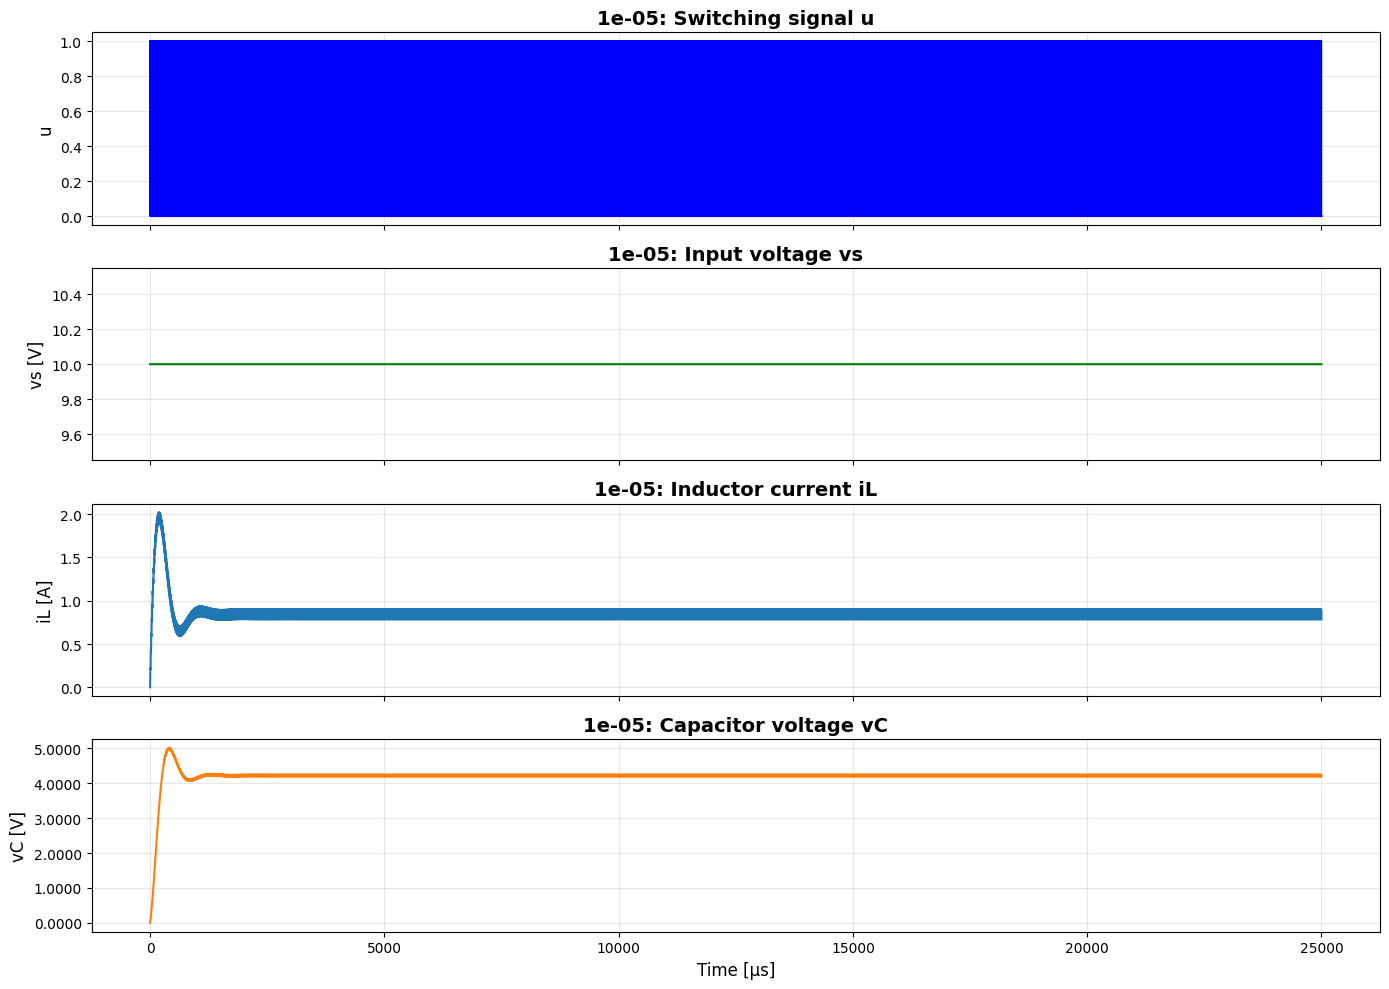

In [121]:
# Duty
window = t_raw > t_raw[-1] - params.T * 10
Vref: float = float(np.mean(vC_raw[window]))
duty: float = Vref / params.Vin
# duty: float = 0.5

# スイッチング信号
duty_phase = (t_raw % params.T) / params.T
u_raw = (duty_phase < duty).astype(int)

# 入力電圧
vs_raw = np.ones(len(t_raw)) * params.Vin

# ダウンサンプリング
_T = int(t_raw[-1] / params.T)
downsample_step = len(t_raw) // (_T * 200)
t_raw_downsampled = t_raw[::downsample_step]
iL_raw_downsampled = iL_raw[::downsample_step]
vC_raw_downsampled = vC_raw[::downsample_step]
u_raw_downsampled = u_raw[::downsample_step][1:]
vs_raw_downsampled = vs_raw[::downsample_step][1:]

print(f"{t_raw_downsampled.shape=}")
print(f"{u_raw_downsampled.shape=}")
print(f"{vs_raw_downsampled.shape=}")
print(f"{iL_raw_downsampled.shape=}")
print(f"{vC_raw_downsampled.shape=}")

fig, ax = plot_u_vs_iL_vC(
    t_raw_downsampled,
    u_raw_downsampled,
    vs_raw_downsampled,
    iL_raw_downsampled,
    vC_raw_downsampled,
    params.T,
)


len(t_buck1)=20001
len(iL_buck1)=20001
len(vC_buck1)=20001
len(u_buck1)=20000
len(vs_buck1)=20000


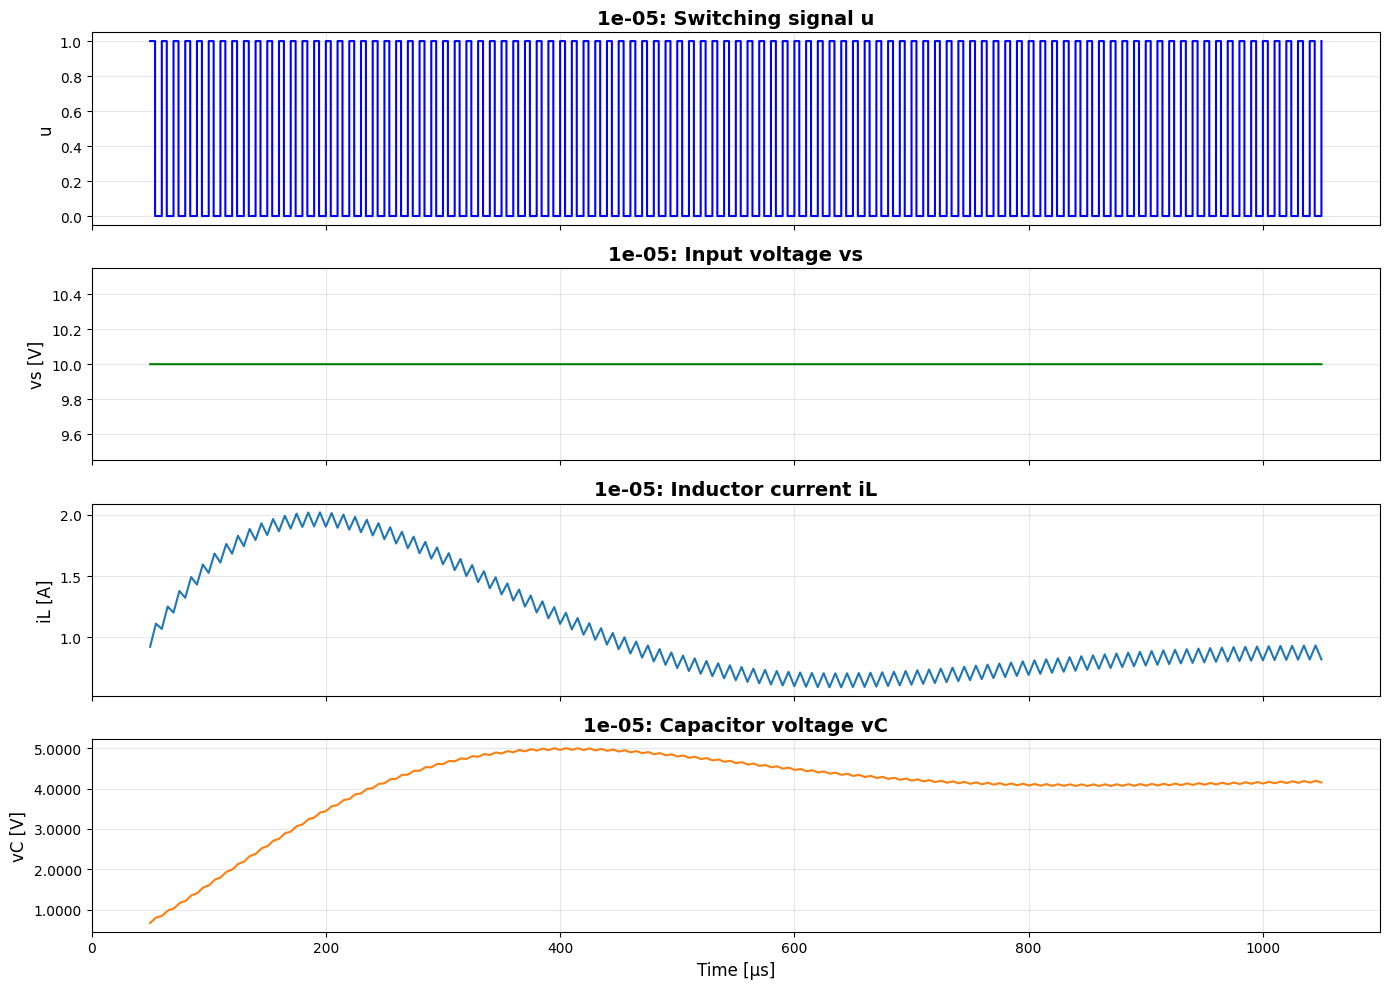

In [122]:
# FIRフィルター
fs_raw = 1.0 / np.mean(np.diff(t_raw_downsampled))
fc = 0.2 * params.f_sw
b_iL = firwin(3, fc, fs=fs_raw)
b_vC = firwin(1000, fc, fs=fs_raw)
iL_filt1 = filtfilt(b_iL, [1.0], iL_raw_downsampled)
vC_filt1 = filtfilt(b_vC, [1.0], vC_raw_downsampled)

# 先頭から 100 周期分を切り出す
mask = (t_raw_downsampled > params.T * 5) & (t_raw_downsampled <= params.T * 105)
t_buck1 = t_raw_downsampled[mask]
iL_buck1 = iL_raw_downsampled[mask]
# iL_buck1 = iL_filt1[mask]
vC_buck1 = vC_raw_downsampled[mask]
# vC_buck1 = vC_filt1[mask]
u_buck1 = u_raw_downsampled[mask[1:]]
vs_buck1 = vs_raw_downsampled[mask[1:]]

u_buck1 = u_buck1[1:]
vs_buck1 = vs_buck1[1:]

print(f"{len(t_buck1)=}")
print(f"{len(iL_buck1)=}")
print(f"{len(vC_buck1)=}")
print(f"{len(u_buck1)=}")
print(f"{len(vs_buck1)=}")

fig, ax = plot_u_vs_iL_vC(
    t_buck1,
    u_buck1,
    vs_buck1,
    iL_buck1,
    vC_buck1,
    params.T,
)

if keep_log:
    save_figure_to_log(
        fig, "BuckConverterCellの入力波形", result_dir, "BuckConverterCellの入力波形"
    )


In [123]:
dt1 = np.ones(len(t_buck1) - 1) * params.dt

# numpy配列をテンソルに変換
dt_tensor1 = torch.tensor(dt1, dtype=torch.float32)
u_tensor1 = torch.tensor(u_buck1, dtype=torch.float32)
vs_tensor1 = torch.tensor(vs_buck1, dtype=torch.float32)
iL_buck_tensor1 = torch.tensor(iL_buck1.copy(), dtype=torch.float32)
vC_buck_tensor1 = torch.tensor(vC_buck1.copy(), dtype=torch.float32)

# train
h_buck_train1 = torch.stack([iL_buck_tensor1[:-1], vC_buck_tensor1[:-1]], dim=1)
x_train1 = torch.stack([vs_tensor1, u_tensor1, dt_tensor1], dim=1)
target_buck_train1 = torch.stack([iL_buck_tensor1[1:], vC_buck_tensor1[1:]], dim=1)

print(f"{h_buck_train1.shape=}")
print(f"{x_train1.shape=}")
print(f"{target_buck_train1.shape=}")

h_buck_train1.shape=torch.Size([20000, 2])
x_train1.shape=torch.Size([20000, 3])
target_buck_train1.shape=torch.Size([20000, 2])


In [124]:
for _dt in sorted(set(dt1)):
    print(f"{_dt=}")

_dt=np.float64(5e-08)


## 学習


In [125]:
buck_converter_cell = BuckConverterCell(
    L_init=params.L_init,
    C_init=params.C_init,
    R_init=params.R_init,
)

optimizer = optim.Adam(
    [
        {"params": [buck_converter_cell.log_L], "lr": params.lr_l},
        {"params": [buck_converter_cell.log_C], "lr": params.lr_c},
        {"params": [buck_converter_cell.log_R], "lr": params.lr_r},
    ]
)

loss_fn = nn.MSELoss()

# 損失履歴を保存
loss_history = {"train": []}
param_history = {"L": [], "C": [], "R": []}

# 学習ループ
for epoch in range(params.epochs):
    # 学習モード
    buck_converter_cell.train()
    optimizer.zero_grad()
    h_pred_train = buck_converter_cell(h_buck_train1, x_train1)
    train_loss = loss_fn(h_pred_train, target_buck_train1)
    train_loss.backward()
    optimizer.step()

    loss_history["train"].append(train_loss.item())

    # パラメータの履歴を保存
    param_history["L"].append(buck_converter_cell.log_L.exp().item())
    param_history["C"].append(buck_converter_cell.log_C.exp().item())
    param_history["R"].append(buck_converter_cell.log_R.exp().item())

    if epoch % 50 == 0:
        output_line = (
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"  L={buck_converter_cell.log_L.exp().item() * 1e6:.1f}µH "
            f"(true={params.L_true * 1e6:.1f})"
            f"C={buck_converter_cell.log_C.exp().item() * 1e6:.1f}µF "
            f"(true={params.C_true * 1e6:.1f})"
            f"R={buck_converter_cell.log_R.exp().item():.2f}Ω "
            f"(true={params.R_true:.1f})"
        )
        print(output_line)


Epoch 0: Train Loss=3.482507e-07,   L=202.0µH (true=223.6)C=100.4µF (true=73.8)R=7.87Ω (true=5.0)
Epoch 50: Train Loss=2.954512e-07,   L=258.8µH (true=223.6)C=77.8µF (true=73.8)R=4.73Ω (true=5.0)
Epoch 100: Train Loss=2.949334e-07,   L=254.1µH (true=223.6)C=73.0µF (true=73.8)R=4.76Ω (true=5.0)
Epoch 150: Train Loss=2.949313e-07,   L=254.4µH (true=223.6)C=73.2µF (true=73.8)R=4.76Ω (true=5.0)
Epoch 200: Train Loss=2.949313e-07,   L=254.4µH (true=223.6)C=73.2µF (true=73.8)R=4.76Ω (true=5.0)
Epoch 250: Train Loss=2.949311e-07,   L=254.4µH (true=223.6)C=73.2µF (true=73.8)R=4.76Ω (true=5.0)
Epoch 300: Train Loss=2.949311e-07,   L=254.4µH (true=223.6)C=73.2µF (true=73.8)R=4.76Ω (true=5.0)
Epoch 350: Train Loss=2.949311e-07,   L=254.4µH (true=223.6)C=73.2µF (true=73.8)R=4.76Ω (true=5.0)
Epoch 400: Train Loss=2.949312e-07,   L=254.4µH (true=223.6)C=73.2µF (true=73.8)R=4.76Ω (true=5.0)
Epoch 450: Train Loss=2.949312e-07,   L=254.4µH (true=223.6)C=73.2µF (true=73.8)R=4.76Ω (true=5.0)
Epoch 500: T

## 結果確認


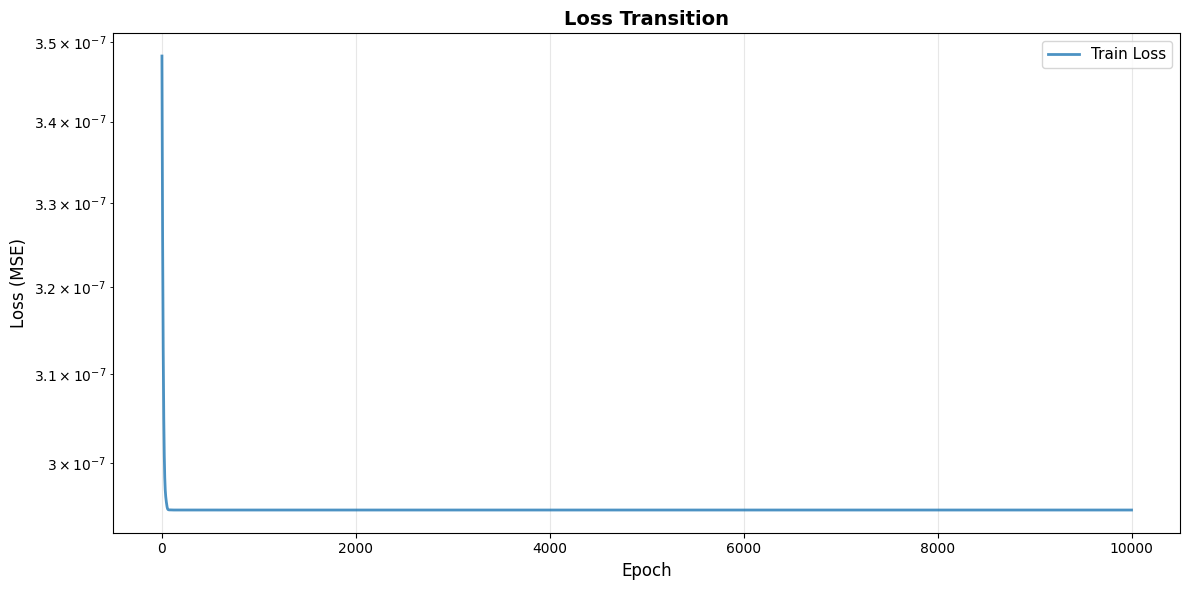

In [126]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, params.epochs + 1)
ax.plot(epochs_list, loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig,
        "BuckConverterCellの学習結果_Lossの遷移",
        result_dir,
        "BuckConverterCellの学習結果_Lossの遷移",
    )


各パラメータの真の値からの百分率誤差（%）:
  L: 13.79 %
  C: 0.78 %
  R: 4.88 %


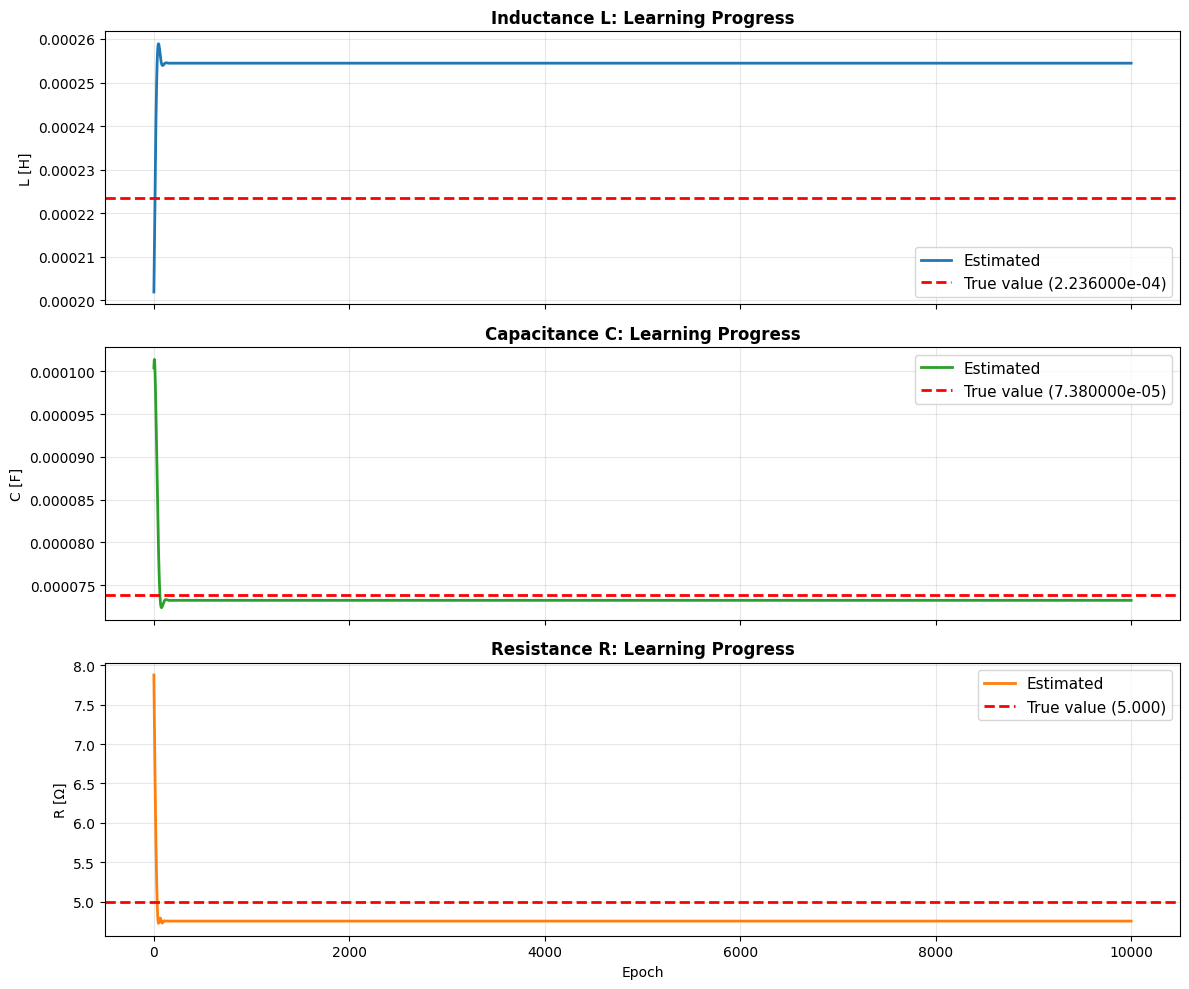

In [127]:
# 回路パラメータの学習による変化をグラフ表示
fig, ax = plot_param_learning_progress(
    param_history,
    params.L_true,
    params.C_true,
    params.R_true,
    params.epochs,
)

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig, "parameter_learning", result_dir, "回路パラメータの学習による変化"
    )

# パラメータごとの推定値（最終エポック時点）を取得
L_pred: float = param_history["L"][-1]
C_pred: float = param_history["C"][-1]
R_pred: float = param_history["R"][-1]

# 正解値との百分率誤差を計算
L_true: float = params.L_true
C_true: float = params.C_true
R_true: float = params.R_true

L_error_percent: float = 100 * abs(L_pred - L_true) / abs(L_true)
C_error_percent: float = 100 * abs(C_pred - C_true) / abs(C_true)
R_error_percent: float = 100 * abs(R_pred - R_true) / abs(R_true)

# 結果を表示（小数点以下2桁まで表示）
print("各パラメータの真の値からの百分率誤差（%）:")
print(f"  L: {L_error_percent:.2f} %")
print(f"  C: {C_error_percent:.2f} %")
print(f"  R: {R_error_percent:.2f} %")


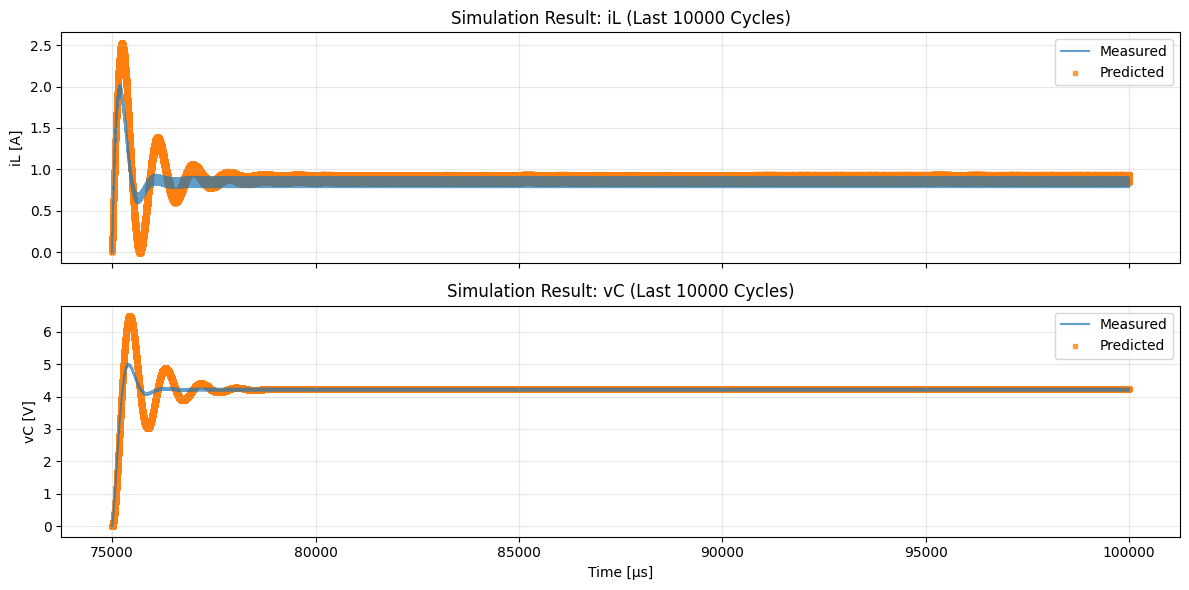

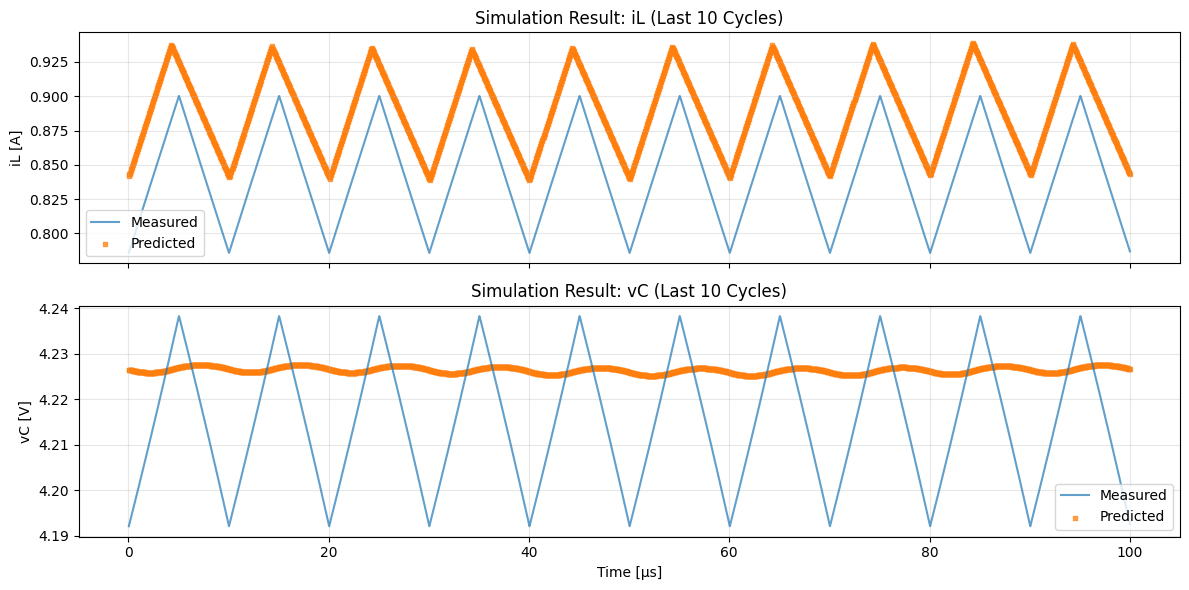

In [128]:
t_sim = np.linspace(
    0,
    params.T * 3000,
    3000 * 200 + 1,
)


dt_sim: np.ndarray = np.diff(t_sim)


# スイッチング信号
duty_phase = (t_sim[:-1] % params.T) / params.T
u_sim = (duty_phase < duty).astype(int)

# 入力電圧
vs_sim = np.ones(len(t_sim) - 1) * params.Vin
x_tensor = torch.tensor(np.c_[vs_sim, u_sim, dt_sim], dtype=torch.float32)

h_sim = [torch.zeros(1, 2)]

# シミュレーション実行
with torch.no_grad():
    for j in range(len(t_sim) - 1):
        h_current = buck_converter_cell(h_sim[-1], x_tensor[j : j + 1])
        h_sim.append(h_current)

h_sim_tensor = torch.cat(h_sim, dim=0)  # shape: (T+1, 2) みたいになる
iL_sim = h_sim_tensor[:, 0]
vC_sim = h_sim_tensor[:, 1]

# グラフ表示
fig, ax = plot_compare_tail(
    t_raw,
    iL_raw,
    vC_raw,
    "Measured",
    t_sim,
    iL_sim,
    vC_sim,
    "Predicted",
    T=params.T,
    title="Simulation Result",
    style2="scatter",
    N_cycles=10000,
)


if keep_log:
    save_figure_to_log(
        fig,
        "all_prediction",
        result_dir,
        f"シミュレーション結果(0から{params.cycles_sim}周期までシミュレーションし、定常箇所と実機のデータの比較)",
    )

fig, ax = plot_compare_tail(
    t_raw,
    iL_raw,
    vC_raw,
    "Measured",
    t_sim,
    iL_sim,
    vC_sim,
    "Predicted",
    T=params.T,
    title="Simulation Result",
    style2="scatter",
)

# GRU


## 前処理

1. 教師データ: (実機データのノイズクリッピング前の波形) - (学習済み BuckConverterCell のおよそ定常部分)
2. 入力データ: iL, vC, vs, u, dt
3. データシーケンスの作成
4. train, valid, test に分割


In [129]:
h_sim = [torch.zeros(1, 2)]

# シミュレーション実行
with torch.no_grad():
    for j in range(len(t_raw_downsampled) - 1):
        h_current = buck_converter_cell(h_sim[-1], x_tensor[j : j + 1])
        h_sim.append(h_current)

h_sim_tensor = torch.cat(h_sim, dim=0)  # shape: (T+1, 2) みたいになる
iL_sim = h_sim_tensor[:, 0]
vC_sim = h_sim_tensor[:, 1]


mask = (t_raw_downsampled > params.T * (_T - 10)) & (t_raw_downsampled <= params.T * _T)


iL_sim_np = iL_sim.detach().cpu().numpy()
vC_sim_np = vC_sim.detach().cpu().numpy()

print(t_raw_downsampled.shape)
print(mask.shape)
print(iL_sim_np.shape)
print(vC_sim_np.shape)

iL_noise = iL_raw_downsampled[mask] - iL_sim_np[mask]
vC_noise = vC_raw_downsampled[mask] - vC_sim_np[mask]

iL_noise_tensor = torch.as_tensor(iL_noise, dtype=torch.float32)
vC_noise_tensor = torch.as_tensor(vC_noise, dtype=torch.float32)


(500000,)
(500000,)
(500000,)
(500000,)


In [130]:
@dataclass(frozen=True)
class Scalers:
    """GRU入力のスケーリング設定。

    - 状態/入力は無次元化（物理基準）
    - ノイズのみ標準化（train統計）し、推論時に必ず逆変換する
    """

    # 無次元化の基準
    v_base: float  # [V]
    i_base: float  # [A]
    t_base: float  # [s]

    # ノイズ標準化（trainのみ）
    noise_mean: torch.Tensor  # (2,)
    noise_std: torch.Tensor  # (2,)

    def nondim_h(self, h: torch.Tensor) -> torch.Tensor:
        """h=[iL,vC] -> 無次元化"""
        iL = h[:, 0] / self.i_base
        vC = h[:, 1] / self.v_base
        return torch.stack([iL, vC], dim=1)

    def nondim_x(self, x: torch.Tensor) -> torch.Tensor:
        """x=[vs,u,dt] -> vs,dtを無次元化。uは0/1なのでそのまま。"""
        vs = x[:, 0] / self.v_base
        u = x[:, 1]
        dt = x[:, 2] / self.t_base
        return torch.stack([vs, u, dt], dim=1)

    def z_noise(self, noise: torch.Tensor) -> torch.Tensor:
        """noise=[iL_noise,vC_noise] -> 標準化"""
        return (noise - self.noise_mean) / self.noise_std

    def inv_z_noise(self, noise_z: torch.Tensor) -> torch.Tensor:
        """標準化ノイズ -> 元スケールへ復元"""
        return noise_z * self.noise_std + self.noise_mean


def fit_scalers_physics(
    *,
    noise_train: torch.Tensor,
    vin: float,
    r_load: float,
    t_base: float,
    eps: float = 1e-8,
) -> Scalers:
    """trainノイズから標準化統計を作り、物理基準の無次元化とセットで返す。"""
    v_base = float(vin)
    i_base = float(vin / r_load)

    noise_mean = noise_train.mean(dim=0)
    noise_std = noise_train.std(dim=0, unbiased=False).clamp_min(eps)

    return Scalers(
        v_base=v_base,
        i_base=i_base,
        t_base=float(t_base),
        noise_mean=noise_mean,
        noise_std=noise_std,
    )


def create_sequences(
    h_data: torch.Tensor,
    x_data: torch.Tensor,
    noise_data: torch.Tensor,
    seq_len: int,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    時系列データを作成
    入力: [iL, vC, vs, u, dt, iL_noise, vC_noise]
    出力: [iL_noise, vC_noise]
    """
    sequences: list[torch.Tensor] = []
    targets: list[torch.Tensor] = []

    for i in range(len(h_data) - seq_len):
        # 入力特徴量: [iL, vC, vs, u, dt] + 過去のノイズ [iL_noise, vC_noise]
        seq_input: list[torch.Tensor] = []
        for j in range(seq_len):
            idx = i + j
            # 状態と入力
            features = torch.cat(
                [
                    h_data[idx],  # [iL, vC]
                    x_data[idx],  # [vs, u, dt]
                ]
            )
            # 過去のノイズ（存在する場合）
            if idx > 0:
                noise_features = noise_data[idx - 1]  # [iL_noise, vC_noise]
            else:
                # device/dtype を揃える
                noise_features = noise_data.new_zeros((2,))
            # 結合: [iL, vC, vs, u, dt, iL_noise, vC_noise] = 7次元
            combined = torch.cat([features, noise_features])
            seq_input.append(combined)

        sequences.append(torch.stack(seq_input))
        targets.append(noise_data[i + seq_len])

    return torch.stack(sequences), torch.stack(targets)


t_gru = t_raw_downsampled[mask]
noise_train_raw = torch.stack([iL_noise_tensor, vC_noise_tensor], dim=1)
vs_train = torch.tensor(vs_raw_downsampled[mask[1:]], dtype=torch.float32)
u_train = torch.tensor(u_raw_downsampled[mask[1:]], dtype=torch.float32)
dt_raw_downsampled = np.ones(len(t_raw_downsampled) - 1) * params.dt
dt_train = torch.tensor(dt_raw_downsampled[mask[1:]], dtype=torch.float32)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)

scalers = fit_scalers_physics(
    noise_train=noise_train_raw,
    vin=float(params.Vin),
    r_load=float(params.R_true),
    t_base=float(params.T),
)

h_train_nd = scalers.nondim_h(noise_train_raw)
x_train_nd = scalers.nondim_x(x_train)
noise_train_z = scalers.z_noise(noise_train_raw)

X_train_seq, y_train_seq = create_sequences(
    h_train_nd,
    x_train_nd,
    noise_train_z,
    params.seq_length,
)


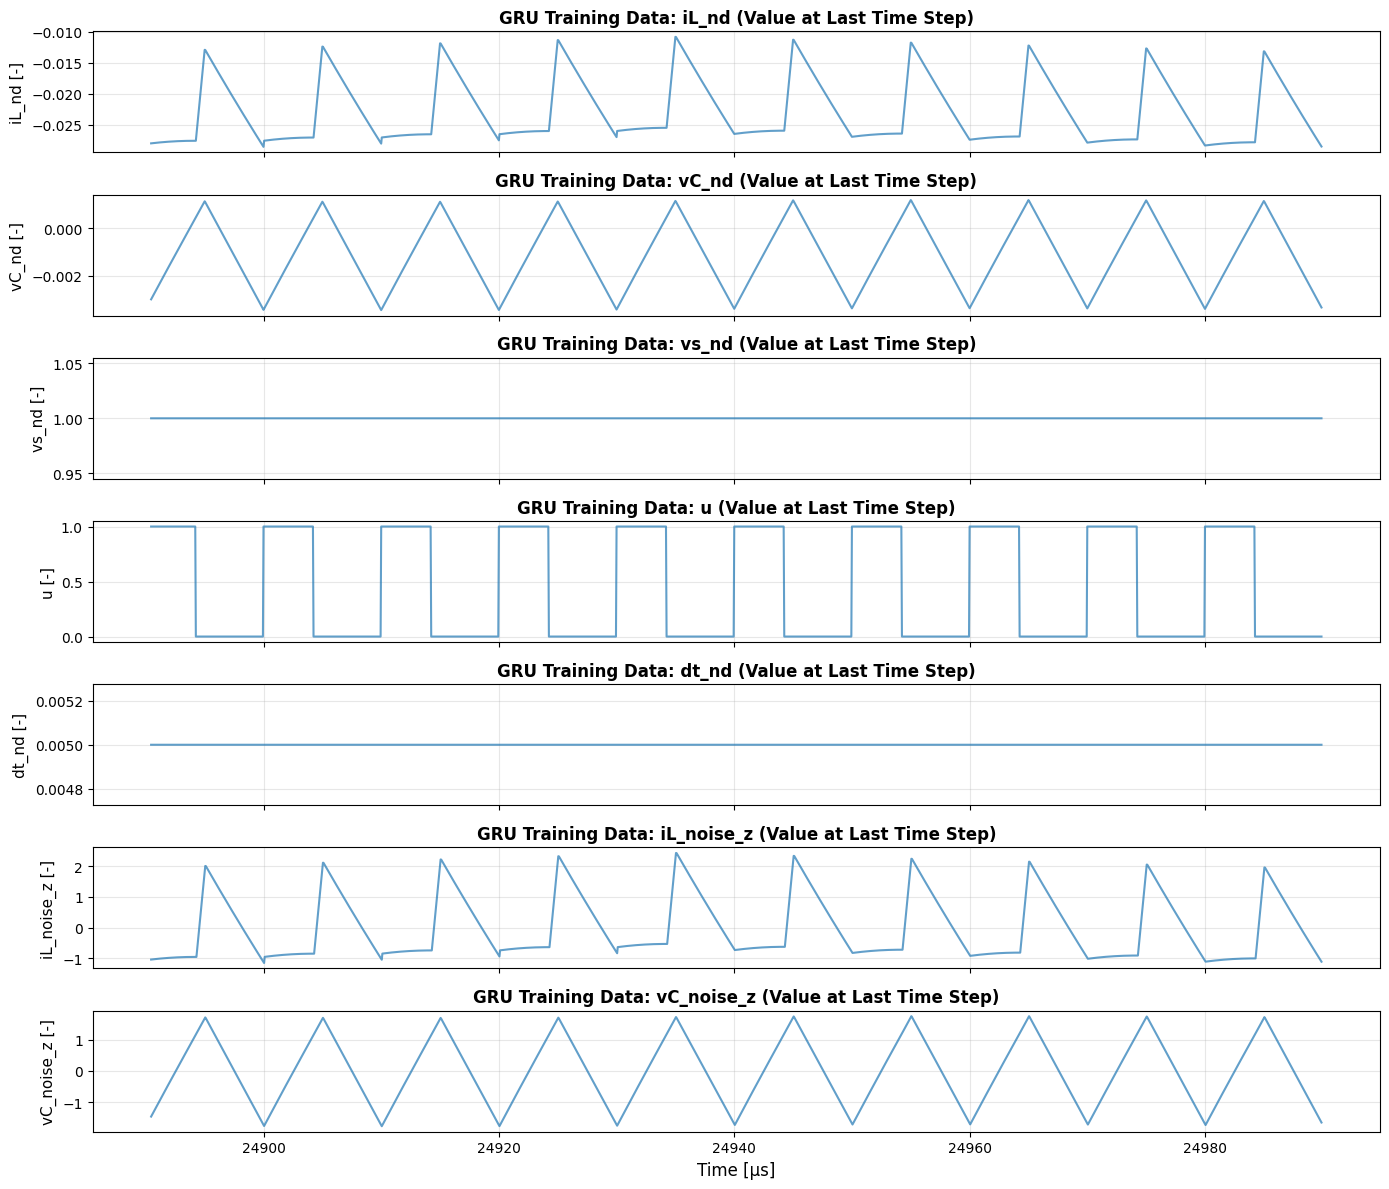

In [131]:
# 学習データ
X_train_seq_np: np.ndarray = X_train_seq.detach().cpu().numpy()
y_train_seq_np: np.ndarray = y_train_seq.detach().cpu().numpy()

# 入力特徴量名と単位（無次元化/標準化後）
feature_names: list[str] = [
    "iL_nd",
    "vC_nd",
    "vs_nd",
    "u",
    "dt_nd",
    "iL_noise_z",
    "vC_noise_z",
]
feature_units: list[str] = ["[-]", "[-]", "[-]", "[-]", "[-]", "[-]", "[-]"]


fig, axs = plt.subplots(7, 1, figsize=(14, 12), sharex=True)

last_timestep_features: np.ndarray = X_train_seq_np[:, -1, :]  # [N, 7]

# 時系列は「各シーケンスの最後の時刻」に合わせる
# seq i の最後のidxは (i + seq_length - 1)
time_axis: np.ndarray = (
    t_gru[
        (int(params.seq_length) - 1) : (
            int(params.seq_length) - 1 + X_train_seq_np.shape[0]
        )
    ]
    * 1e6
)  # μs

for i in range(7):
    axs[i].plot(time_axis, last_timestep_features[:, i], linewidth=1.5, alpha=0.7)
    axs[i].set_ylabel(f"{feature_names[i]} {feature_units[i]}", fontsize=11)
    axs[i].grid(True, alpha=0.3)
    axs[i].set_title(
        f"GRU Training Data: {feature_names[i]} (Value at Last Time Step)",
        fontsize=12,
        fontweight="bold",
    )

axs[6].set_xlabel("Time [μs]", fontsize=12)
plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig,
        "gru_training_data_features",
        result_dir,
        "GRU 学習データ",
    )


## 学習


In [132]:
# 学習
gru_model = GRUModel(
    input_size=X_train_seq.shape[2],
    hidden_size=32,
    num_layers=2,
    output_size=2,
    seq_length=params.seq_length,
)


gru_optimizer = optim.Adam(gru_model.parameters(), lr=params.gru_lr)
gru_loss_fn = nn.MSELoss()

gru_loss_history = {"train": [], "valid": []}

for epoch in range(params.gru_epochs):
    # 学習モード
    gru_model.train()
    gru_optimizer.zero_grad()
    noise_pred_train = gru_model(X_train_seq)
    train_loss = gru_loss_fn(noise_pred_train, y_train_seq)
    train_loss.backward()
    gru_optimizer.step()

    gru_loss_history["train"].append(float(train_loss.item()))

    if (epoch + 1) % 50 == 0:
        print(
            f"Epoch {epoch + 1}/{params.gru_epochs}: Train Loss={train_loss.item():.6e}"
        )


Epoch 50/200: Train Loss=3.096411e-02
Epoch 100/200: Train Loss=1.286782e-02
Epoch 150/200: Train Loss=8.931418e-03
Epoch 200/200: Train Loss=6.624005e-03


## 結果確認


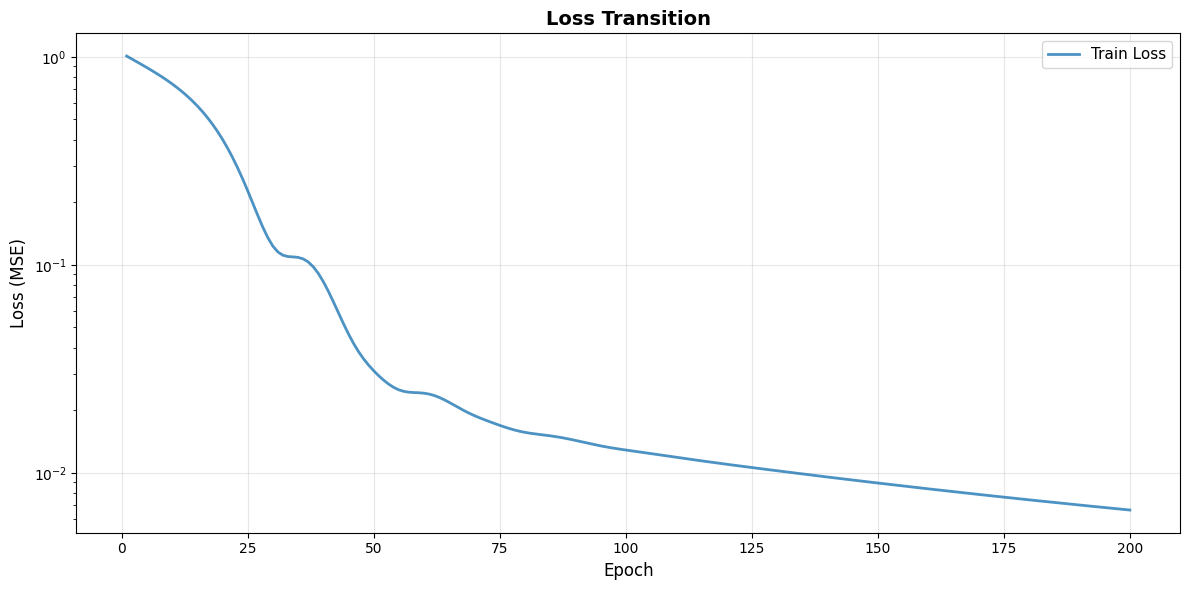

In [133]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, params.gru_epochs + 1)
ax.plot(
    epochs_list, gru_loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8
)


ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "gru_loss_transition", result_dir, "GRU Lossの遷移")


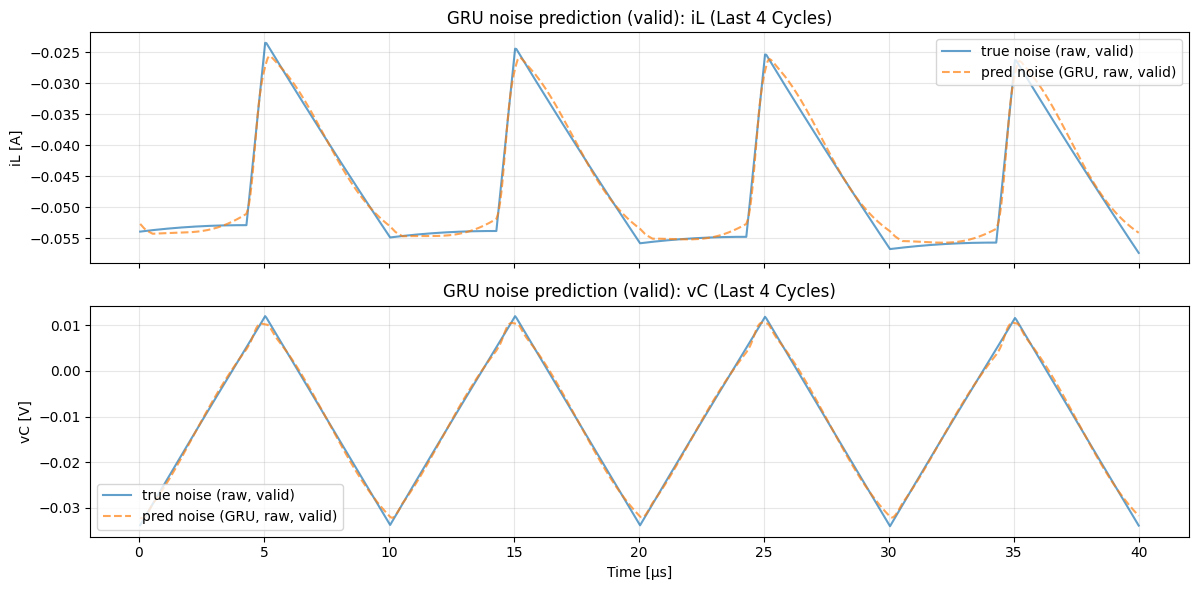

In [134]:
# GRUでノイズを予測
gru_model.eval()
with torch.no_grad():
    noise_pred_train = gru_model(X_train_seq)

# t_gruの長さとpred_noise_rawの長さを揃える
pred_noise_raw = scalers.inv_z_noise(noise_pred_train.detach().cpu()).numpy()

_len = pred_noise_raw.shape[0]

fig1, _ = plot_compare_tail(
    t1=t_gru[-_len:],
    iL1=iL_noise[-_len:],
    vC1=vC_noise[-_len:],
    label1="true noise (raw, valid)",
    t2=t_gru[-_len:],
    iL2=pred_noise_raw[:, 0],
    vC2=pred_noise_raw[:, 1],
    label2="pred noise (GRU, raw, valid)",
    T=float(params.T),
    N_cycles=4,
    title="GRU noise prediction (valid)",
)

if keep_log:
    save_figure_to_log(
        fig1,
        "gru_noise_pred_valid",
        result_dir,
        "GRU noise予測(valid)",
    )


# BuckConverterCell + GRU の結果


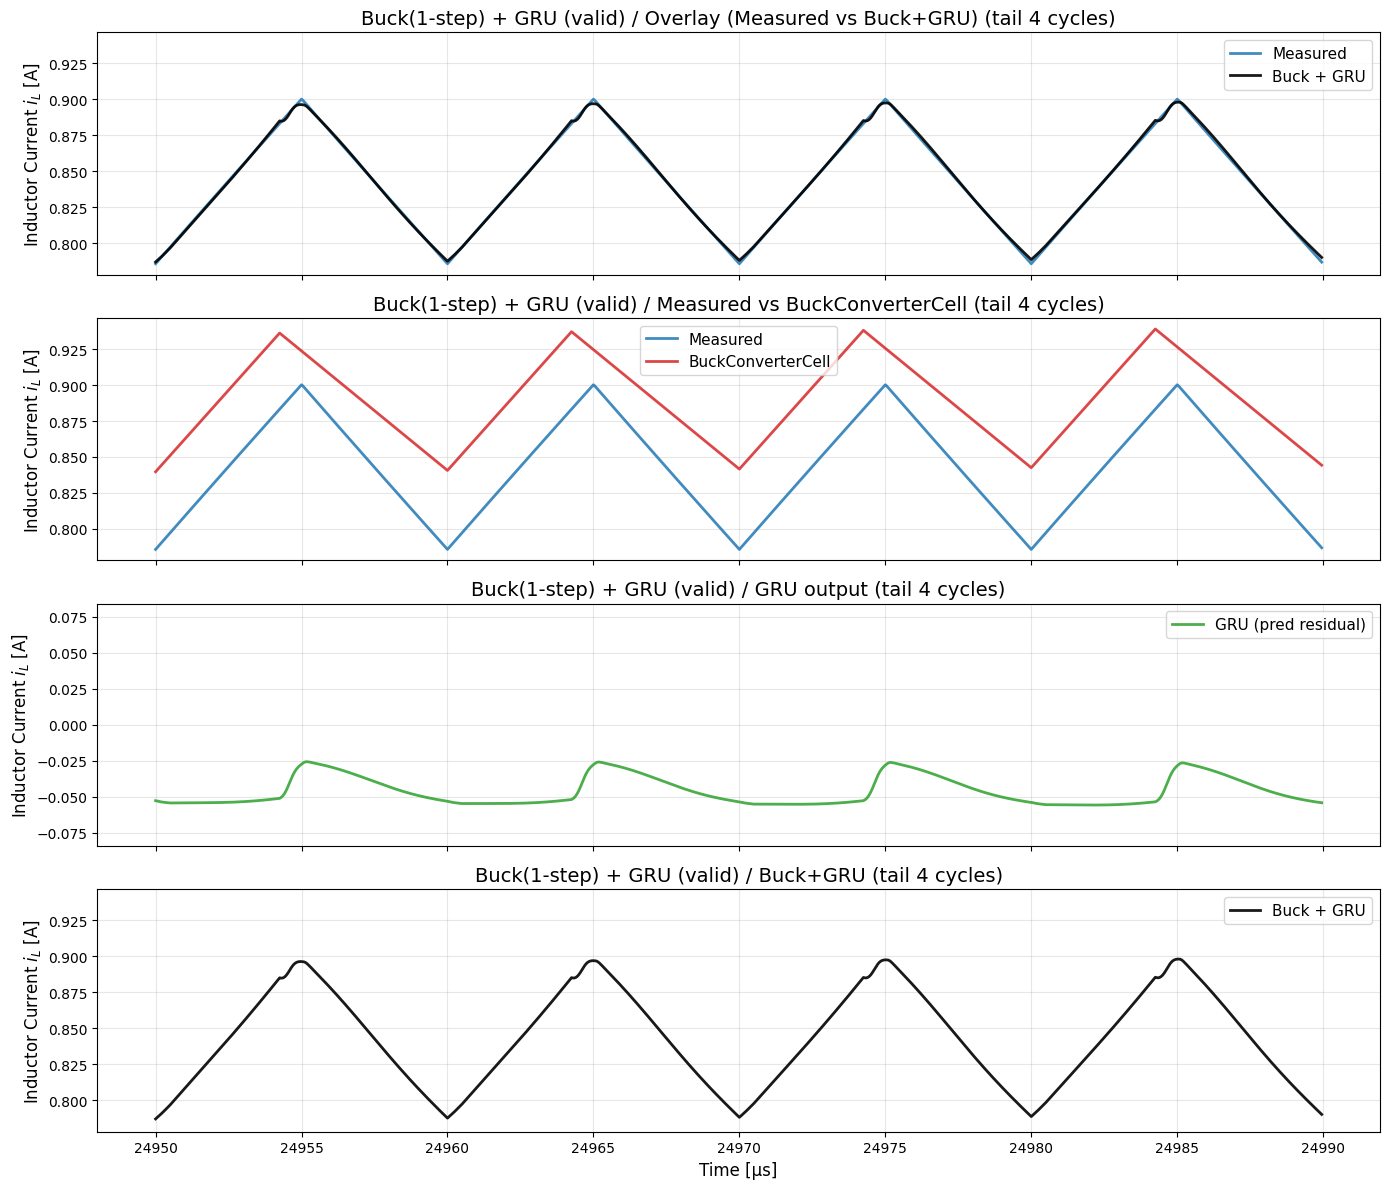

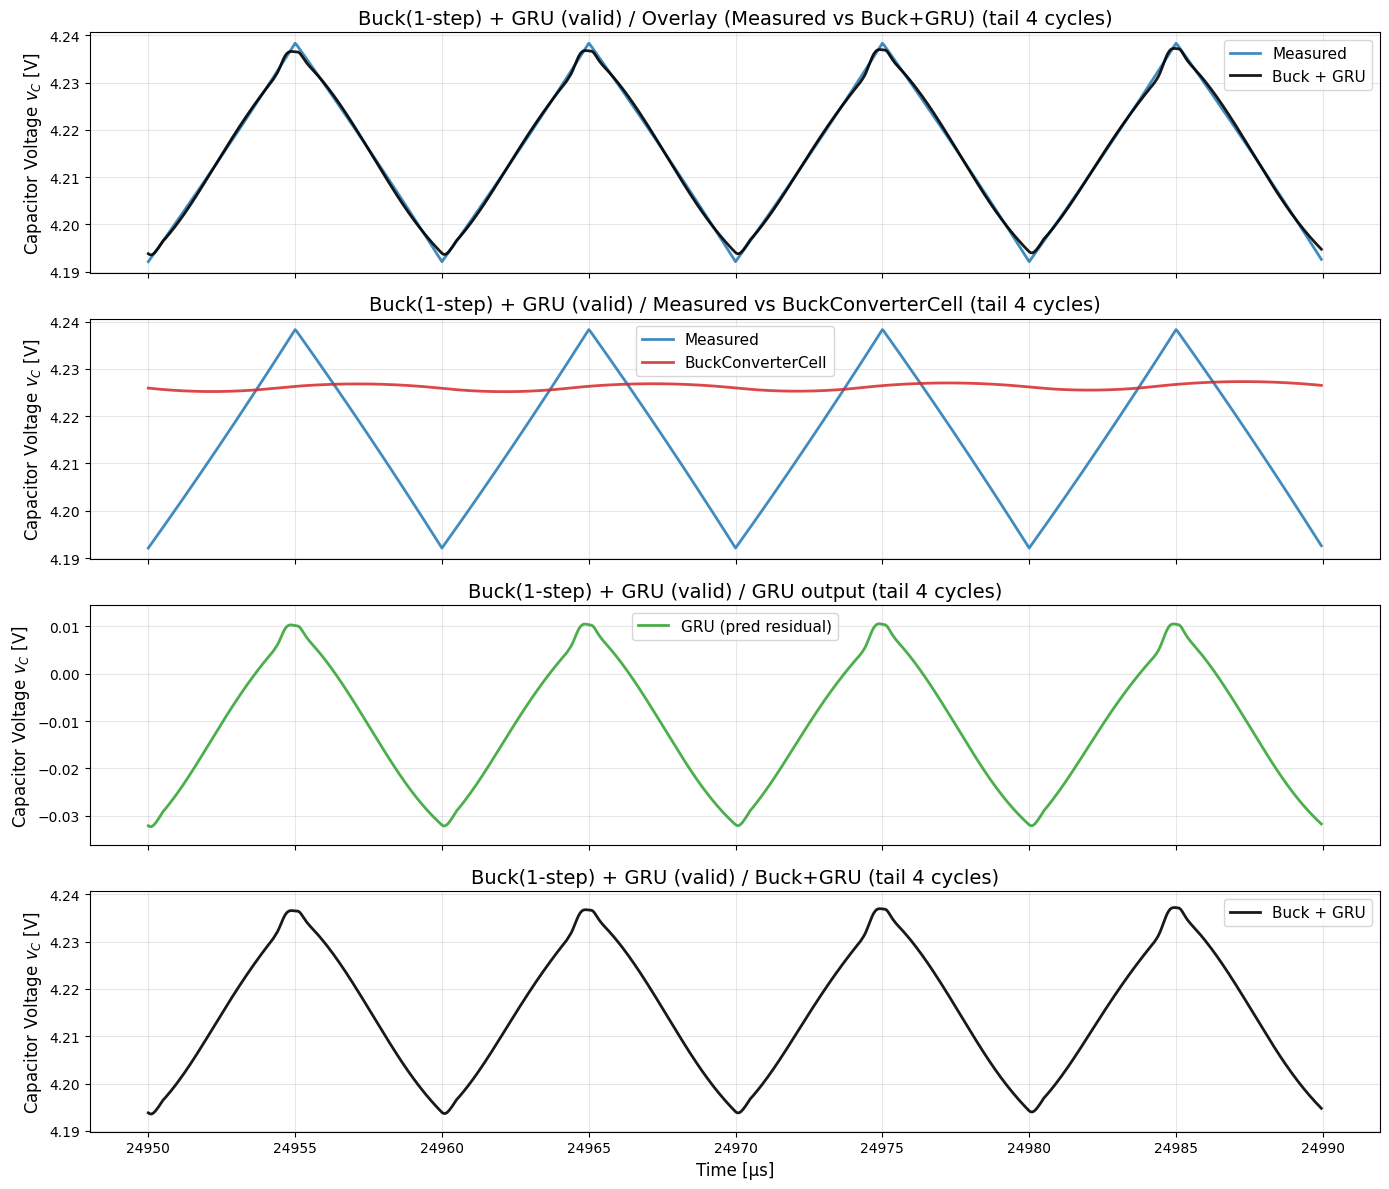

In [135]:
fig_iL, _, fig_vC, _ = plot_buck_gru_components_tail(
    t=t_raw_downsampled[mask][-_len:],
    iL_meas=iL_raw_downsampled[mask][-_len:],
    vC_meas=vC_raw_downsampled[mask][-_len:],
    iL_buck=iL_sim[mask][-_len:],
    vC_buck=vC_sim[mask][-_len:],
    iL_gru=pred_noise_raw[:, 0],
    vC_gru=pred_noise_raw[:, 1],
    T=float(params.T),
    N_cycles=4,
    title="Buck(1-step) + GRU (valid)",
    include_overlay=True,
)
plt.show()

if keep_log:
    save_figure_to_log(
        fig_iL,
        "tail4T_iL_meas_buck1step_gru_sum_valid",
        result_dir,
        "iL: Measured(next) / Buck(1-step) / GRU / Buck+GRU（valid, 末尾4周期）",
    )
    save_figure_to_log(
        fig_vC,
        "tail4T_vC_meas_buck1step_gru_sum_valid",
        result_dir,
        "vC: Measured(next) / Buck(1-step) / GRU / Buck+GRU（valid, 末尾4周期）",
    )
